## Objective
- To provide a file sync experience(and eficciency) similar to `repo sync`, or `awscli s3 sync`, etc.
- Allow files to be uploaded on downloaded **ONLY** if there is a difference in the file's loacal cs remote copy
- Provide a pip package that wraps this sync access to s3 remote assets
- Provide this as a convinience package for using remote assets in notebooks

## Procedure
- allow downloading or uploading files to an s3 bucket.
- when asked to download a file from s3:
  - check if the file is already present in the local directory
  - if the file is present in the local directory:
    - check if its hash matches the hash of the s3 version of this file
    - if there is a mismatch in the hash of the file between the local and the s3 copy, it means that the contents of the file has changed
    - if hashes mismatch: proceed with download
- when asked to upload a file to s3:
  - repeat the same process as involved in dowloading a file

## Available appraoches
- Option 1: wrap the command line call to `awscli s3 sync` using python `subprocess` library
- Option 2: write the sync functionality from scratch ✅

## Dependencies
- boto3

In [1]:
import os
from botocore.exceptions import NoCredentialsError
import shutil
import boto3 as boto
import multiprocessing
import copy
import hashlib
import logging
from pathlib import Path
log = logging.getLogger(__name__)

class LocalObjectCache:
    """Provides a local cache of an S3 bucket on disk, with the ability to sync up to the latest version of all files"""
    _DEFAULT_PATH = '/tmp/local_object_store/'

    def __init__(self, bucket_name, prefix='', path=None):
        """Init Method
        :param bucket_name: str, the name of the S3 bucket
        :param prefix: str, the prefix up to which you want to sync
        :param path: (optional, str) a path to store the local files
        """
        self.bucket_name = bucket_name
        self.prefix = prefix

        if not path:
            path = self._DEFAULT_PATH + self.bucket_name + '/'

        self.path = path
        os.makedirs(path, exist_ok=True)

        s3 = boto.resource('s3')
        self.bucket = s3.Bucket(self.bucket_name)

    def __enter__(self):
        """Provides a context manager which will open but not sync, then delete the cache on exit"""
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        """Provides a context manager which will open but not sync, then delete the cache on exit"""
        self.close()

    def __getstate__(self):
        # Require to pickle and un-pickle the self object between multiprocessing pools
        out = copy.copy(self.__dict__)
        out['bucket'] = None
        return out

    def __setstate__(self, d):
        # Require to pickle and un-pickle the self object between multiprocessing pools
        s3 = boto.resource('s3')
        d['bucket'] = s3.Bucket(d['bucket_name'])
        self.__dict__ = d

    def get_path(self, key):
        """Returns the local file storage path for a given file key"""
        return os.path.join(self.path, self.prefix, key)

    @staticmethod
    def calculate_s3_etag(file, chunk_size=8 * 1024 * 1024):
        """Calculates the S3 custom e-tag (a specially formatted MD5 hash)"""
        md5s = []
        
        while True:
            data = file.read(chunk_size)
            if not data:
                break
            md5s.append(hashlib.md5(data))

        if len(md5s) == 1:
            return '"{}"'.format(md5s[0].hexdigest())

        digests = b''.join(m.digest() for m in md5s)
        digests_md5 = hashlib.md5(digests)
        return '"{}-{}"'.format(digests_md5.hexdigest(), len(md5s))

    def _get_obj(self, key, tag=None):
        """Downloads an object at key to file path, checking to see if an existing file matches the current hash"""
        path = os.path.join(self.path, key)
        os.makedirs(os.path.dirname(path), exist_ok=True)
        dl_flag = True
        try:
            f = open(path, 'rb')
            if tag == self.calculate_s3_etag(f):
                log.info('Cache Hit')
                dl_flag = False
            f.close()
        except FileNotFoundError as e:
            pass

        if dl_flag:
            log.info('Cache Miss')
            self.bucket.download_file(key, path)
    
    def _set_obj(self, key, path=None):
        """Uploads an object at key to aws, checking to see if an existing file matches the current hash"""
        path = os.path.join(self.path, self.prefix+Path(key).name)
        os.makedirs(os.path.dirname(path), exist_ok=True)
        dl_flag = True
        try:
            f = open(path, 'rb')
            file = open(key, 'rb')
            key_tag = self.calculate_s3_etag(file)
            cache_tag = self.calculate_s3_etag(f)
            if key_tag==cache_tag:
                log.info('cache Hit')
                dl_flag = False
            file.close()
            f.close()
        except FileNotFoundError as e:
            pass

        if dl_flag:
            log.info('Cache Miss')
            self.bucket.upload_file(key, self.prefix+Path(key).name)
            return self.calculate_s3_etag(open(key, 'rb'))

    def sync(self):
        """Syncs the local and remote S3 copies"""
        pool = multiprocessing.Pool()
        keys = [(obj.key, obj.e_tag) for obj in self.bucket.objects.filter(Prefix=self.prefix)]
        pool.starmap(self._get_obj, keys)

    def close(self):
        """Deletes all local files"""
        shutil.rmtree(self.path)


### Examples for using above class.

#### Example 1 
Uploads an obj from key to aws after checking if a directory with the hash value exists in local directory or not returns a new tag if file has made some changes or a new file is uploading.

In [15]:
'''Create object of the LocalObjectCache to initialize the bucket name and prefix.'''
bucket_name = 'sentientx'
prefix = 'EOD/'
obj = LocalObjectCache(bucket_name, prefix)

"""Uploading an obj from key to aws."""
__file = 'feather_files/feather_1024.fth'
obj._set_obj(os.path.abspath(__file))

#### Example 2

_get_obj is called to download files on the system from aws bucket, checks if the file exists on local cache with the same tag.

In [4]:
'''Create object of the LocalObjectCache to initialize the bucket name and prefix.'''
bucket_name = 'sentientx'
prefix = 'EOD/'
obj = LocalObjectCache(bucket_name, prefix)

'''Downloading a key from obj.'''
__filename__ = 'feather_512.fth'
key = os.path.join(obj.prefix, __filename__)
obj._get_obj(key, 'hello')

#### Example 3
Syncing the data of local and remote s3 bucket.

In [ ]:
'''Create object of the LocalObjectCache to initialize the bucket name and prefix.'''
bucket_name = 'sentientx'
prefix = 'EOD/'
obj = LocalObjectCache(bucket_name, prefix)

"""Syncs the data of remote s3 bucket and local directory."""
obj.sync()

#### Example 4
To reset the bucket name and to get the details of current bucket.

In [ ]:
'''Create object of the LocalObjectCache to initialize the bucket name and prefix.'''
bucket_name = 'sentientx'
prefix = 'EOD/'
obj = LocalObjectCache(bucket_name, prefix)

"""Shows the details of the object or changes the state of the object during multiprocessing."""
obj.__getstate__()

#### Example 5 
To set the state of object during multiprocessing.

In [22]:
'''Create object of the LocalObjectCache to initialize the bucket name and prefix.'''
bucket_name = 'sentientx'
prefix = 'EOD/'
obj = LocalObjectCache(bucket_name, prefix)

"""Syncs the data of local and remote s3 bucket and changes the state of the object during multiprocessing."""
obj.__setstate__('sentientx')

#### Example 6
To delete the all files from the local cache.

In [ ]:
'''Create object of the LocalObjectCache to initialize the bucket name and prefix.'''
bucket_name = 'sentientx'
prefix = 'EOD/'
obj = LocalObjectCache(bucket_name, prefix)

"""Delete all files from the local cache."""
obj.close()

## Uploading and downloading 30 files on aws
Here, we will upload and download the data of 30 companies and analysing their time consumption on uploading and downloading the data with or without cache. We had already upload and downloaded the data on aws bucket and local cache memory respectively.

In [5]:
import timeit

'''making dictionary for storing time taken for uploading and downloading.'''

time_dict = dict()
time_dict['upload'] = dict()
time_dict['download'] = dict()
time_dict['upload']['without_cache'] = dict()
time_dict['download']['with_cache'] = dict()
time_dict['upload']['with_cache'] = dict()
time_dict['download']['without_cache'] = dict()

__file__ = 'feather_files'
path = os.path.abspath(__file__)
files = os.listdir(path)
bucket = 'sentientx'
prefix='EOD/'

'''Creating object of for local cache.'''
object = LocalObjectCache(bucket, prefix)

'''creating session for direct upload and download.'''
s4 = boto.client('s3')

'''Pre download and upload the files.'''
for file in files:
    object._set_obj(os.path.abspath(os.path.join(__file__, file)))
    object._get_obj(os.path.join(object.prefix, file), '')

i=0
for file in files:
    i += 1
    tag = object.calculate_s3_etag(open(os.path.abspath(os.path.join(__file__, file)), 'rb'))
    
    uploading_time = %timeit -q -n1 -o s4.upload_file(os.path.abspath(os.path.join(__file__, file)), bucket, os.path.join(prefix,file))
    time_dict['upload']['without_cache'][i] = uploading_time.best
    uploading_time = %timeit -q -n1 -o object._set_obj(os.path.abspath(os.path.join(__file__, file)))
    time_dict['upload']['with_cache'][i] = uploading_time.best

    downloading_time = %timeit -q -n1 -o s4.download_file(bucket , os.path.join(prefix, file), os.path.abspath(os.path.join(__file__, file)))
    time_dict['download']['without_cache'][i] = downloading_time.best
    tag = object.calculate_s3_etag(open(os.path.abspath(os.path.join(__file__, file)), 'rb'))
    downloading_time = %timeit -q -n1 -o object._get_obj(os.path.join(object.prefix, file),tag )
    time_dict['download']['with_cache'][i] = downloading_time.best


In [45]:
'''Creating dataframe of the time_dict '''
dic = {'upload' : pd.DataFrame(time_dict['upload']), 'download' : pd.DataFrame(time_dict['download'])}
res = pd.concat(dic.values(),axis=1,keys=dic.keys())

## Downloading a file multiple times of same data with different names.
Let's check by downloading a file multiple times of same data by changing its name using cache and without cache. Checking if with cache file with download multiple times or not.

In [8]:
new_dict = dict()
new_dict['download'] = dict()
new_dict['download']['with_cache'] = dict()
new_dict['download']['without_cache'] = dict()

__file__ = 'feather_files'
path = os.path.abspath(__file__)
files = os.listdir(path)
bucket_name = 'sentientx'
prefix='EOD/'

path1 = '/aws/download/'
os.makedirs(path1, exist_ok=True)

'''Creating object of for local cache.'''
object = LocalObjectCache(bucket_name, prefix)

'''creating session for direct upload and download.'''
s4 = boto.resource('s3')
bucket = s4.Bucket(bucket_name)
for file in files:
    for i in range(10):
        download_time = %timeit -q -n1 -o bucket.download_file(os.path.join(prefix, file), os.path.abspath(os.path.join(path1, str(i)+file)))
        new_dict['download']['without_cache'][i] = download_time.best
        new_file = os.path.abspath(os.path.join(path1, str(i)+file))
        tag = object.calculate_s3_etag(open(new_file, 'rb'))
        download_time = %timeit -q -n1 -o object._get_obj(os.path.join(object.prefix, file), tag)
        new_dict['download']['with_cache'][i] = download_time.best
    break

In [38]:
import pandas as pd
count = pd.DataFrame({'No. of files':[len(os.listdir(os.path.abspath(path1))),len(os.listdir(object.path))]}, index=['without_cache', 'with_cache'])
count

,No. of files
without_cache,10
with_cache,1


## Comparison between upload time and download time of data with or without cache


In [61]:
difference_in_upload = sum(res['upload']['without_cache']) - sum(res['upload']['with_cache']) 
difference_in_download = sum(res['download']['without_cache']) - sum(res['download']['with_cache'])
percentage_difference_in_upload = difference_in_upload *100 / 100
percentage_difference_in_download = difference_in_download *100 / 100
standard_diffrence_in_upload = res['upload']['without_cache'].std() - res['upload']['with_cache'].std()
standard_diffrence_in_download = res['download']['without_cache'].std() - res['download']['with_cache'].std()
print(r'Uploading time of without cache is taking {:.2f}% ({:.4f})more time than Uploading time of with cache.'.format(percentage_difference_in_upload, standard_diffrence_in_upload))
print(r'Downloading time of without cache is taking {:.2f}% ({:.4f})more time than Downloading time of with cache.'.format(percentage_difference_in_download, standard_diffrence_in_download))

Uploading time of without cache is taking 4.67% (0.0400)more time than Uploading time of with cache.


## Plot the graph
Let's plot the graph to visualize the comparison between the uploading and downloading time of files with or without cache.

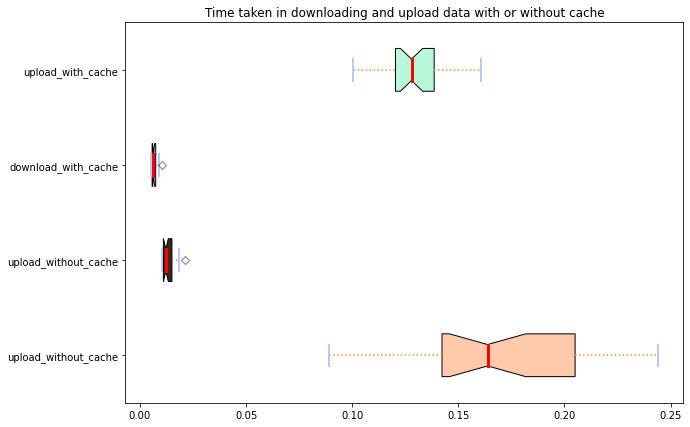

In [62]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
bp = ax.boxplot(res, patch_artist = True,
                notch ='True', vert = 0)
 
colors = ['#ffcaab', '#3d271c', '#e4cfea', '#b8f9d9']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
for whisker in bp['whiskers']:
    whisker.set(color ='#f88e36',
                linewidth = 1.5,
                linestyle =":")
 
for cap in bp['caps']:
    cap.set(color ='#b8c8f9',
            linewidth = 2)
 
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#f9b8b8',
              alpha = 0.5)
     
ax.set_yticklabels(['upload_without_cache', 'upload_without_cache',
                    'download_with_cache', 'upload_with_cache'])
 
plt.title("Time taken in downloading and upload data with or without cache")
 
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
plt.show()

<Figure size 720x576 with 0 Axes>

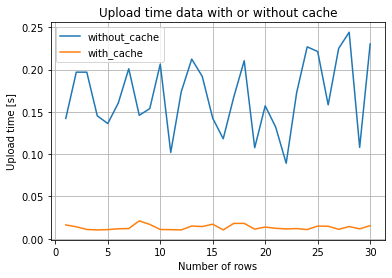

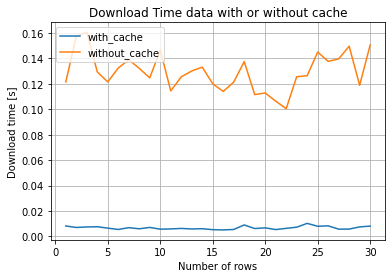

In [67]:
fig = plt.figure(figsize=(10,8))

# Upload times
res['upload'].plot()
plt.xlabel('Number of rows')
plt.ylabel('Upload time [s]')
plt.title('Upload time data with or without cache')
plt.grid()
plt.legend(loc=2)

# Reading times
res['download'].plot()
plt.xlabel('Number of rows')
plt.ylabel('Download time [s]')
plt.title('Download Time data with or without cache')
plt.grid()
plt.legend(loc=2)


# Conclusion

|Uploading|Downloading|
|:---:|:---:|
|Uploading time of without cache is taking 4.67% (0.0400)more time than Uploading time of with cache.|Downloading time of without cache is taking 3.69% (0.0136)more time than Downloading time of with cache.|
|Uploads a file single time with cache and mupltiple times without cache if we upload the file of same data multiple times.|Downloads a file single time with cache and mupltiple times without cache if we download the file of same data multiple times.|